In [1]:
# Modules...
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torchio as tio
import nibabel as nib
from scipy.ndimage import label, generate_binary_structure, binary_dilation, binary_erosion

from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold

from IPython.display import clear_output
from timm.models.layers import DropPath

In [2]:
# CUDA device
torch.cuda.is_available()
GPU_NUM = 4
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) 
print ('Current cuda device Number =', torch.cuda.current_device())

if device.type == 'cuda':
    print('Current cuda device Name =', torch.cuda.get_device_name(GPU_NUM))
    print('Current cuda device Memory = {:.2f}GB'.format((torch.cuda.get_device_properties(GPU_NUM).total_memory) * 1e-9))

Current cuda device Number = 4
Current cuda device Name = NVIDIA RTX A6000
Current cuda device Memory = 51.05GB


In [3]:
# volume preprocessing methods

def crop_sample(volume, mask, thr=8):
    #volume[volume < np.max(volume) * 0.1] = 0          # intensity 낮으면 0 (max*0.1 보다 작으면)
    
    # crop xaxial                                      
    v_min, v_max = 0, 0                                        
    for i in range(np.shape(volume)[0]):
        x_axis = volume[i,:,:]
        x_num_nonzero = len(np.where(x_axis>0)[0])
        if x_num_nonzero > 0 and v_min == 0:
            v_min = i
        elif x_num_nonzero > 0 and v_min > 0:
            v_max = i           
    if v_min%thr != 0:
        v_min = v_min-(v_min%thr)
    if v_max%thr != 0:
        v_max = v_max+(thr-(v_max%thr))   
        
    x_min, x_max = v_min, v_max
        
    # crop y-axial
    v_min, v_max = 0, 0
    for j in range(np.shape(volume)[1]):
        y_axis = volume[:,j,:]
        num_nonzero = len(np.where(y_axis>0)[0])
        if num_nonzero > 0 and v_min == 0:
            v_min = j
        elif num_nonzero > 0 and v_min > 0:
            v_max = j
    if v_min%thr != 0:
        v_min = v_min-(v_min%thr)
    if v_max%thr != 0:
        v_max = v_max+(thr-(v_max%thr))
            
    y_min, y_max = v_min, v_max
    
        
    # crop z-axial                                     # z축따라 0 보다 낮은 intensity는 자르기
    v_min, v_max = 0, 0
    for k in range(np.shape(volume)[2]):
        z_axis = volume[:,:,k]      
        num_nonzero = len(np.where(z_axis>0)[0])
        
        if num_nonzero > 0 and v_min == 0:
            v_min = k
        elif num_nonzero > 0 and v_min > 0:
            v_max = k
    
    if v_min%thr != 0:
        v_min = v_min-(v_min%thr)
    if v_max%thr != 0:
        v_max = v_max+(thr-(v_max%thr))
        
    if v_max > np.shape(volume)[2]:
        pad = v_max-np.shape(volume)[2]
        v_max = v_max - pad
        v_min = v_min - pad
        
    if v_min < 0:
        v_min = 6

    if v_max%2==1:
        v_max -= 1
    
    if (v_max-v_min)%thr != 0:
        v_min=4
    if (v_max-v_min)%thr != 0:
        v_min=2
    
    z_min, z_max = v_min, v_max
    
    
    return (
        volume[x_min:x_max,y_min:y_max,z_min:z_max],
        mask[x_min:x_max,y_min:y_max,z_min:z_max]
    )


# z-score
def normalize_volume(volume):
    nonzero_volume = volume[volume > 0]
    mean = nonzero_volume.mean()
    std  = nonzero_volume.std()
    volume = (volume - mean) / std
    return volume

def Max_min_normalize_volume(volume):
    Max = np.max(volume)
    Min = np.min(volume)
    volume = (volume - Min) / (Max - Min)
    return volume


# custom dataloader
class BrainSegmentationDataset(Dataset):     
    # split dataset and read the specified partition
    def __init__(self,images_dir, transform=None,mode="train",K=0,num_folds=5,random_state=10,val_split=0.1):
        assert mode in ["train", "validation", "test"]
        self.transform = transform
        self.mode = mode
        volumes = []
        masks = []
        files = []
        
        # subject weights (by the number of foreground voxels)
        subj_weights = np.zeros((len(os.listdir(images_dir)),))
        cnt = 0
        for (dirpath, dirnames, filenames) in os.walk(images_dir):
            if len(filenames) == 2:  # image, label
                if "truth" in filenames[1]: 
                    tmpmask_fname = filenames[1]
                    tmpmask = nib.load(os.path.join(dirpath,tmpmask_fname)).get_fdata()
                    tmpidx = np.where(tmpmask > 0.5)[-1]
                    subj_weights[cnt] = len(tmpidx)
                    cnt = cnt + 1

        # split the subjects by median value
        subj_weights = np.where(subj_weights > np.median(subj_weights),1,0)
        
        # select dataset : k-fold cross validation (stratified)
        cnt_idx = np.arange(len(os.listdir(images_dir))) # 0, 1, 2, ..., num_subj-1
        kf = StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=random_state)
        train_indices,validation_indices,test_indices = {},{},{}
        cnt = 0
        for train_validation_idx, test_idx in kf.split(cnt_idx,subj_weights): 
            splits = train_test_split(train_validation_idx, 
                                    shuffle=True,
                                    random_state=random_state,
                                    test_size=val_split,
                                    stratify=subj_weights[train_validation_idx])
            train_indices[str(cnt)], validation_indices[str(cnt)] = splits[0], splits[1]
            test_indices[str(cnt)] = test_idx
            cnt += 1

        if mode == 'train':
            sel = train_indices[str(K)]
        elif mode == 'validation':
            sel = validation_indices[str(K)]
        elif mode == 'test':
            sel = test_indices[str(K)]
        
        # read images
        print("reading {} images...".format(mode))
        print("The length of {} set is: {}".format(mode, len(sel)))
        cnt = 0
        for (dirpath, dirnames, filenames) in os.walk(images_dir):
            subj_batch = {}
            if len(filenames) == 2:  # if both of image and mask were prepared
                if np.any(sel==cnt):
                    subj_num = filenames[0].split("_")[0]
                    files.append(subj_num)
                    for f in range(2): 
                        if "truth" in filenames[f]: # read the mask fname
                            mask_fname = filenames[f]
                        else: # read the image fname
                            image_fname = filenames[f]      
                        
                    subj_batch['mask'] = nib.load(os.path.join(dirpath,mask_fname)).get_fdata()
                    subj_batch['image'] = nib.load(os.path.join(dirpath,image_fname)).get_fdata()
                    if len(subj_batch) == 2: # volume preprocessing
                        #cropping
                        subj_batch['image'], subj_batch['mask'] = crop_sample(subj_batch['image'], subj_batch['mask'])
                        # normalize
                        subj_batch['image'] = normalize_volume(subj_batch['image'])
                        #stack
                        volumes.append(subj_batch['image'])
                        masks.append(subj_batch['mask'])
                cnt += 1
        
        print("Number of volumes {} set is: {}".format(mode, len(volumes)))
        self.volumes = volumes
        self.masks = masks
        print("Number of image size {} set is: {}".format(mode, np.shape(self.volumes)))
        print("Number of label size {} set is: {}".format(mode, np.shape(self.masks)))
        
        self.files = files
        print(self.files)     

    # return the number of samples
    def __len__(self):
        return len(self.volumes)

    def __getitem__(self, idx):
        image = self.volumes[idx]
        mask = self.masks[idx] 

        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask)        
        image = torch.unsqueeze(image,0)
        mask = torch.unsqueeze(mask,0)
        
        if self.transform is not None and self.mode == 'train' :
            image, mask = self.transform(image=image, mask=mask, idx=idx)       
        return image, mask
    
    
def transform(image, mask, idx, mode='train'):
    # assure the same transformation for both image and target
    subject_dict = {
        'image': tio.ScalarImage(tensor=image),
        'mask': tio.LabelMap(tensor=mask),
    }
    
    subject = tio.Subject(subject_dict)
    # A set of transform objects...
    #spatial
    transform_nothing = tio.Lambda(lambda x:x, types_to_apply=None)
    transform_xFlip = tio.RandomFlip(axes=0,flip_probability=1.0)
    transform_yFlip = tio.RandomFlip(axes=1,flip_probability=1.0)
    transform_zFlip = tio.RandomFlip(axes=2,flip_probability=1.0)
    transform_rotation_scale = tio.RandomAffine(scales=(0.95,1.25), degrees=15, image_interpolation='linear',isotropic=True, center='image')
    
    #intensity
    transform_gamma = tio.RandomGamma(log_gamma=(-0.3, 0.3))
    
    # transform 확률
    transforms_dict = {
        transform_nothing: 0.5,
        transform_xFlip: 0.1,
        transform_yFlip: 0.1,
        transform_zFlip: 0.1,
        transform_rotation_scale: 0.1,
        transform_gamma: 0.1
    }
    
    # 여러 transform을 함께 구성
    transforms = tio.OneOf(transforms_dict)

    # augmentaion for only train phase
    assert mode in ["train", "validation", "test"]
    if mode=='train':
        subject = transforms(subject)
        
    return subject['image'].tensor, subject['mask'].tensor  # volume preprocessing methods

In [4]:
class Initial_block(nn.Module):
    def __init__(self, channels, group_num):
        super(Initial_block, self).__init__()
        
        self.norm1 = nn.GroupNorm(num_groups=group_num, num_channels=channels)
        #self.norm1 = nn.BatchNorm3d(num_features=channels)
        self.act1 = nn.ReLU()
        self.conv1 = nn.Conv3d(channels, channels, 3, stride=1, padding=1)
        
        self.norm2 = nn.GroupNorm(num_groups=group_num, num_channels=channels)
        #self.norm2 = nn.BatchNorm3d(num_features=channels)
        self.act2 = nn.ReLU()
        self.conv2 = nn.Conv3d(channels, channels, 3, stride=1, padding=1, groups=channels)
        
        self.norm3 = nn.GroupNorm(num_groups=group_num, num_channels=channels)
        #self.norm3 = nn.BatchNorm3d(num_features=channels)
        self.act3 = nn.ReLU()
        self.conv3 = nn.Conv3d(channels, channels, 1, stride=1, padding=0)
        
        self.norm4 = nn.GroupNorm(num_groups=group_num, num_channels=channels)
        #self.norm4 = nn.BatchNorm3d(num_features=channels)
        self.act4 = nn.ReLU()
        self.conv4 = nn.Conv3d(channels, channels, 3, stride=1, padding=1, groups=channels)
        
    def forward(self, x):
        y = self.conv1(self.act1(self.norm1(x)))
        y = self.conv2(self.act2(self.norm2(y)))
        y = self.conv3(self.act3(self.norm3(y)))
        y = self.conv4(self.act4(self.norm4(y)))
        return y

    
class LargeKernelReparam(nn.Module):
    def __init__(self, channels, kernel, small_kernels=()):
        super(LargeKernelReparam, self).__init__()
        
        self.dw_large = nn.Conv3d(channels, channels, kernel, padding=kernel//2, groups=channels)
        
        self.small_kernels = small_kernels
        for k in self.small_kernels:
            setattr(self, f"dw_small_{k}", nn.Conv3d(channels, channels, k, padding=k//2, groups=channels))
            
    def forward(self, inp):
        outp = self.dw_large(inp)
        for k in self.small_kernels:
            outp += getattr(self, f"dw_small_{k}")(inp)
        return outp        
    

class encblock(nn.Module):
    def __init__(self, channels, group_num, kernel=13, small_kernels=(5,), mlp_ratio=4.0, drop=0.3, drop_path=0.5):
        super(encblock, self).__init__()
        self.kernel=kernel
        self.small_kernels=small_kernels
        self.drop=drop
        self.drop_path=drop_path
        
        self.norm1 = nn.GroupNorm(num_groups=group_num, num_channels=channels)
        #self.norm1 = nn.BatchNorm3d(num_features=channels)
        self.act1 = nn.ReLU()
        self.conv1 = nn.Conv3d(channels, channels, 1, stride=1, padding=0)
        
        self.norm2 = nn.GroupNorm(num_groups=group_num, num_channels=channels)
        #self.norm2 = nn.BatchNorm3d(num_features=channels)
        self.act2 = nn.ReLU()
        self.lkr2 = LargeKernelReparam(channels, self.kernel, self.small_kernels)
        
        self.norm3 = nn.GroupNorm(num_groups=group_num, num_channels=channels)
        #self.norm3 = nn.BatchNorm3d(num_features=channels)
        self.act3 = nn.ReLU()
        self.conv3 = nn.Conv3d(channels, channels, 1, stride=1, padding=0)
        
        self.norm4 = nn.GroupNorm(num_groups=group_num, num_channels=channels)
        #self.norm4 = nn.BatchNorm3d(num_features=channels)
        self.act4 = nn.GELU()
        self.mlp4 = nn.Conv3d(channels, int(channels*mlp_ratio), 1, stride=1, padding=0)
        
        self.norm5 = nn.GroupNorm(num_groups=group_num, num_channels=int(channels*mlp_ratio))
        #self.norm5 = nn.BatchNorm3d(num_features=int(channels*mlp_ratio))
        self.act5 = nn.GELU()
        self.mlp5 = nn.Conv3d(int(channels*mlp_ratio), channels, 1, stride=1, padding=0)
        
        self.dropout = nn.Dropout(self.drop)
        self.droppath = DropPath(self.drop_path) if self.drop_path > 0. else nn.Identity()
            
    def forward(self, x):
        y = self.conv1(self.act1(self.norm1(x)))
        y = self.lkr2(self.act2(self.norm2(y)))
        y = self.conv3(self.act3(self.norm3(x)))
        x = x + self.droppath(y)
        
        y = self.mlp4(self.act4(self.norm4(x)))
        y = self.dropout(y)
        y = self.mlp5(self.act5(self.norm5(y)))
        y = self.dropout(y)
        x = x + self.droppath(y)
        return x


class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, group_num):
        super(DownSample, self).__init__()
        
        self.norm1 = nn.GroupNorm(num_groups=group_num, num_channels=in_channels)
        #self.norm1 = nn.BatchNorm3d(num_features=in_channels)
        self.act1 = nn.ReLU()
        self.conv1 = nn.Conv3d(in_channels, out_channels, 1)
        
        self.norm2 = nn.GroupNorm(num_groups=group_num, num_channels=out_channels)
        #self.norm2 = nn.BatchNorm3d(num_features=out_channels)
        self.act2 = nn.ReLU()
        self.conv2 = nn.Conv3d(out_channels, out_channels, 3, stride=2, padding=1, groups=out_channels) #안되면 group 뺴고 해보기
    
    def forward(self, x):
        y = self.conv1(self.act1(self.norm1(x)))
        y = self.conv2(self.act2(self.norm2(y)))
        return y
    
    
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, group_num):
        super(UpSample, self).__init__()
        
        self.norm1 = nn.GroupNorm(num_groups=group_num, num_channels=in_channels)
        #self.norm1 = nn.BatchNorm3d(num_features=in_channels)
        self.act1 = nn.ReLU()
        self.conv1 = nn.Conv3d(in_channels, out_channels, 1)
        
        self.norm2 = nn.GroupNorm(num_groups=group_num, num_channels=out_channels)
        #self.norm2 = nn.BatchNorm3d(num_features=out_channels)
        self.act2 = nn.ReLU()
        self.up2 = nn.ConvTranspose3d(out_channels, out_channels, 2, stride=2, groups=out_channels) #안되면 groups 빼고 해보기
        
    def forward(self, x):
        y = self.conv1(self.act1(self.norm1(x)))
        y = self.up2(self.act2(self.norm2(y)))
        return y


class decblock(nn.Module):
    def __init__(self, in_channels, out_channels, group_num):
        super(decblock, self).__init__()
        
        self.norm1 = nn.GroupNorm(num_groups=group_num, num_channels=in_channels)
        #self.norm1 = nn.BatchNorm3d(num_features=in_channels)
        self.relu1 = nn.ReLU()
        self.conv1 = nn.Conv3d(in_channels, out_channels, 3, stride=1, padding=1)
        
        self.norm2 = nn.GroupNorm(num_groups=group_num, num_channels=out_channels)
        #self.norm2 = nn.BatchNorm3d(num_features=out_channels)
        self.relu2 = nn.ReLU()
        self.conv2 = nn.Conv3d(out_channels, out_channels, 3, stride=1, padding=1, groups=out_channels)

    def forward(self, x):
        y = self.conv1(self.relu1(self.norm1(x)))
        y = self.conv2(self.relu2(self.norm2(y)))
        return y


class Unet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=14, group_num=7):
        super(Unet, self).__init__()
        
        self.init_conv = nn.Conv3d(in_channels, features, 1, stride=1, padding=0)
        self.init_block = Initial_block(features, group_num)
        
        self.encoder1_1 = encblock(features, group_num, drop_path=0.0)
        self.encoder1_2 = encblock(features, group_num, drop_path=0.0)
        self.down1 = DownSample(features, features*2, group_num)
        
        self.encoder2_1 = encblock(features*2, group_num, drop_path=0.2)
        self.encoder2_2 = encblock(features*2, group_num, drop_path=0.2)
        self.down2 = DownSample(features*2, features*4, group_num)
        
        self.encoder3_1 = encblock(features*4, group_num, drop_path=0.3)
        self.encoder3_2 = encblock(features*4, group_num, drop_path=0.3)
        self.down3 = DownSample(features*4, features*8, group_num)
        
        self.encoder4_1 = encblock(features*8, group_num, drop_path=0.5)
        self.encoder4_2 = encblock(features*8, group_num, drop_path=0.5)
        self.encoder4_3 = encblock(features*8, group_num, drop_path=0.5)
        self.encoder4_4 = encblock(features*8, group_num, drop_path=0.5)
        
        self.up3 = UpSample(features*8, features*4, group_num)
        self.decoder3_1 = decblock(features*(4+4), features*4, group_num)
        self.decoder3_2 = decblock(features*4, features*4, group_num)
        
        self.up2 = UpSample(features*4, features*2, group_num)
        self.decoder2_1 = decblock(features*(2+2), features*2, group_num)
        self.decoder2_2 = decblock(features*2, features*2, group_num)
        
        self.up1 = UpSample(features*2, features, group_num)
        self.decoder1_1 = decblock(features*(1+1), features, group_num)
        self.decoder1_2 = decblock(features, features, group_num)
        
        self.conv = nn.Conv3d(features, out_channels, 1, stride=1 , padding=0)
        self.sigmoid = nn.Sigmoid()
#        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):                 # batch, 1, H, W, D
        enc0_1 = self.init_conv(x)          # batch, 14, H, W, D
        enc0_2 = self.init_block(enc0_1) 
        
        enc1_1 = self.encoder1_1(enc0_2)    
        enc1_2 = self.encoder1_2(enc1_1)  
        dwn1 = self.down1(enc1_2)         # batch, 28, H/2, W/2, D/2
        
        enc2_1 = self.encoder2_1(dwn1)    
        enc2_2 = self.encoder2_2(enc2_1)  
        dwn2 = self.down2(enc2_2)         # batch, 56, H/4, W/4, D/4
        
        enc3_1 = self.encoder3_1(dwn2)    
        enc3_2 = self.encoder3_2(enc3_1)  
        dwn3 = self.down3(enc3_2)         # batch, 112, H/8, W/8, D/8
        
        enc4_1 = self.encoder4_1(dwn3)    
        enc4_2 = self.encoder4_2(enc4_1)  
        enc4_3 = self.encoder4_3(enc4_2)  
        enc4_4 = self.encoder4_4(enc4_3)  
        
        up3 = self.up3(enc4_4)                     # batch, 128, H/4, W/4, D/4
        concat3 = torch.cat((enc3_2, up3), dim=1)  # batch, 128+64, H/4, W/4, D/4
        dec3_1 = self.decoder3_1(concat3)          # batch, 64, H/4, W/4, D/4
        dec3_2 = self.decoder3_2(dec3_1)
        
        up2 = self.up2(dec3_2)                     # batch, 64, H/2, W/2, D/2
        concat2 = torch.cat((enc2_2, up2), dim=1)  # batch, 64+32, H/2, W/2, D/2
        dec2_1 = self.decoder2_1(concat2)          # batch, 32, H/2, W/2, D/2
        dec2_2 = self.decoder2_2(dec2_1)
        
        up1 = self.up1(dec2_2)                     # batch, 32, H, W, D
        concat1 = torch.cat((enc1_2, up1), dim=1)  # batch, 32+16, H, W, D
        dec1_1 = self.decoder1_1(concat1)          # batch, 16, H, W, D
        dec1_2 = self.decoder1_2(dec1_1)

        dec1_out = self.conv(dec1_2)                # batch, 1, H, W, D
        out1 = self.sigmoid(dec1_out)
#        out1 = self.softmax(dec1_out)

        return out1
        
        
        
# call the model
model = Unet()
model.to(device)

Unet(
  (init_conv): Conv3d(1, 14, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (init_block): Initial_block(
    (norm1): GroupNorm(7, 14, eps=1e-05, affine=True)
    (act1): ReLU()
    (conv1): Conv3d(14, 14, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (norm2): GroupNorm(7, 14, eps=1e-05, affine=True)
    (act2): ReLU()
    (conv2): Conv3d(14, 14, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=14)
    (norm3): GroupNorm(7, 14, eps=1e-05, affine=True)
    (act3): ReLU()
    (conv3): Conv3d(14, 14, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (norm4): GroupNorm(7, 14, eps=1e-05, affine=True)
    (act4): ReLU()
    (conv4): Conv3d(14, 14, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=14)
  )
  (encoder1_1): encblock(
    (norm1): GroupNorm(7, 14, eps=1e-05, affine=True)
    (act1): ReLU()
    (conv1): Conv3d(14, 14, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (norm2): GroupNorm(7, 14, eps=1e-05, affine=True)
    (act2): ReLU()
 

In [5]:
def plot_img(inputs, label, predicted):
    inputs = inputs.squeeze()
    label = label.squeeze()
    predicted = predicted.squeeze()
    
    inputs = (inputs.cpu()).numpy()
    label = (label.cpu()).numpy()
    predicted = (predicted.cpu()).numpy()

    inputs = inputs.astype(np.float64)   
    label = label.astype(np.uint8)
    predicted = predicted.astype(np.uint8)
    
    fig = plt.figure(figsize=(5,5))
    ax1 = fig.add_subplot(1,3,1)
    ax1.imshow(inputs, cmap="gray")
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax2 = fig.add_subplot(1,3,2)
    ax2.imshow(label, cmap='gray', vmin=0, vmax=1)
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax3 = fig.add_subplot(1,3,3)
    ax3.imshow(predicted, cmap='gray',vmin=0, vmax=1)
    ax3.set_xticklabels([])
    ax3.set_yticklabels([])      

    plt.show()
    
    
class dsc(nn.Module):
    def __init__(self, smooth=1e-6):
        super(dsc, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):      
        assert inputs.size() == targets.size()
        #flatten label and prediction tensors
        inputs = inputs.contiguous().view(-1)
        targets = targets.contiguous().view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_coef = (2.*intersection + self.smooth) / ((inputs*inputs).sum() + (targets*targets).sum() + self.smooth)
        
        return dice_coef

In [6]:
def data_loaders(path,batch_size,K=0):
    dataset_train, dataset_valid, dataset_test = datasets(path, K=K)

    
    loader_train = DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True

    )
    loader_valid = DataLoader(
        dataset_valid,
        batch_size=1,
        shuffle=False,
        drop_last=False

    )
    loader_test = DataLoader(
        dataset_test,
        batch_size=1,
        shuffle=False,
        drop_last=False

    )

    return loader_train, loader_valid, loader_test


def datasets(images, K=0, num_folds=5,random_state=2023,val_split=0.2):
    train = BrainSegmentationDataset(
        images_dir=images,
        mode="train",
        transform=transform,
        K=K,num_folds=num_folds,random_state=random_state,val_split=val_split,
    )
    valid = BrainSegmentationDataset(
        images_dir=images,
        mode="validation",
        transform=None,
        K=K,num_folds=num_folds,random_state=random_state,val_split=val_split,
    )
    test = BrainSegmentationDataset(
        images_dir=images,
        mode="test",
        transform=None,
        K=K,num_folds=num_folds,random_state=random_state,val_split=val_split,
    )
    return train, valid, test

In [7]:
# hyperparameters
batch_size = 1
epochs = 300
learning_rate = 1e-4
weights = '/nasdata4/son/PEstudy_KYJ/weights/'
dice = dsc()

input_channels = 1
output_channels = 1
num_features = 16
group_features = 8
path = '/nasdata4/son/PEstudy_KYJ/Datasets'

# call the model
model = Unet(in_channels=input_channels, out_channels=output_channels, features=num_features, group_num=group_features)
model.to(device)


# call the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# call the dataloader
loader_train, loader_valid, loader_test = data_loaders(path=path, batch_size=batch_size, K=3)
loaders = {"train": loader_train, "valid": loader_valid, "test" : loader_test}

reading train images...
The length of train set is: 47
Number of volumes train set is: 47
Number of image size train set is: (47,)
Number of label size train set is: (47,)
['LUNG1-001.nii', 'LUNG1-002.nii', 'LUNG1-008.nii', 'LUNG1-016.nii', 'LUNG1-018.nii', 'LUNG1-024.nii', 'LUNG1-028.nii', 'LUNG1-035.nii', 'LUNG1-046.nii', 'LUNG1-050.nii', 'LUNG1-053.nii', 'LUNG1-060.nii', 'LUNG1-065.nii', 'LUNG1-068.nii', 'LUNG1-097.nii', 'LUNG1-107.nii', 'LUNG1-113.nii', 'LUNG1-117.nii', 'LUNG1-128.nii', 'LUNG1-143.nii', 'LUNG1-149.nii', 'LUNG1-168.nii', 'LUNG1-170.nii', 'LUNG1-177.nii', 'LUNG1-186.nii', 'LUNG1-195.nii', 'LUNG1-196.nii', 'LUNG1-242.nii', 'LUNG1-252.nii', 'LUNG1-253.nii', 'LUNG1-277.nii', 'LUNG1-285.nii', 'LUNG1-299.nii', 'LUNG1-301.nii', 'LUNG1-303.nii', 'LUNG1-307.nii', 'LUNG1-312.nii', 'LUNG1-314.nii', 'LUNG1-320.nii', 'LUNG1-325.nii', 'LUNG1-331.nii', 'LUNG1-336.nii', 'LUNG1-343.nii', 'LUNG1-361.nii', 'LUNG1-376.nii', 'LUNG1-377.nii', 'LUNG1-396.nii']


/home/son/anaconda3/envs/daft/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


reading validation images...
The length of validation set is: 12
Number of volumes validation set is: 12
Number of image size validation set is: (12,)
Number of label size validation set is: (12,)
['LUNG1-013.nii', 'LUNG1-038.nii', 'LUNG1-051.nii', 'LUNG1-091.nii', 'LUNG1-148.nii', 'LUNG1-286.nii', 'LUNG1-296.nii', 'LUNG1-340.nii', 'LUNG1-362.nii', 'LUNG1-366.nii', 'LUNG1-381.nii', 'LUNG1-418.nii']


/home/son/anaconda3/envs/daft/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


reading test images...
The length of test set is: 15
Number of volumes test set is: 15
Number of image size test set is: (15,)
Number of label size test set is: (15,)
['LUNG1-005.nii', 'LUNG1-026.nii', 'LUNG1-042.nii', 'LUNG1-088.nii', 'LUNG1-115.nii', 'LUNG1-156.nii', 'LUNG1-205.nii', 'LUNG1-229.nii', 'LUNG1-249.nii', 'LUNG1-291.nii', 'LUNG1-348.nii', 'LUNG1-367.nii', 'LUNG1-387.nii', 'LUNG1-416.nii', 'LUNG1-420.nii']


/home/son/anaconda3/envs/daft/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


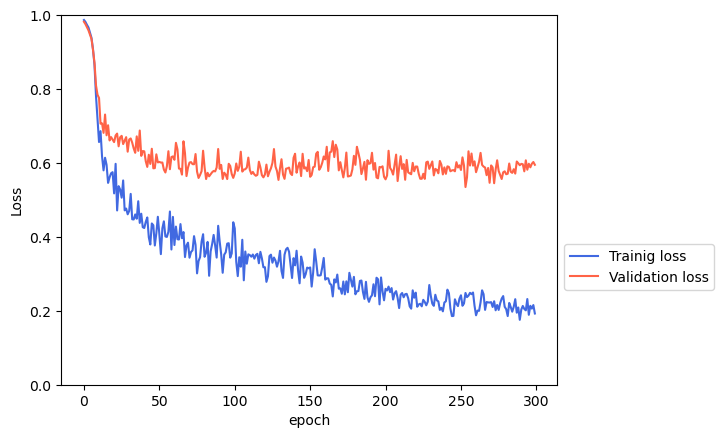

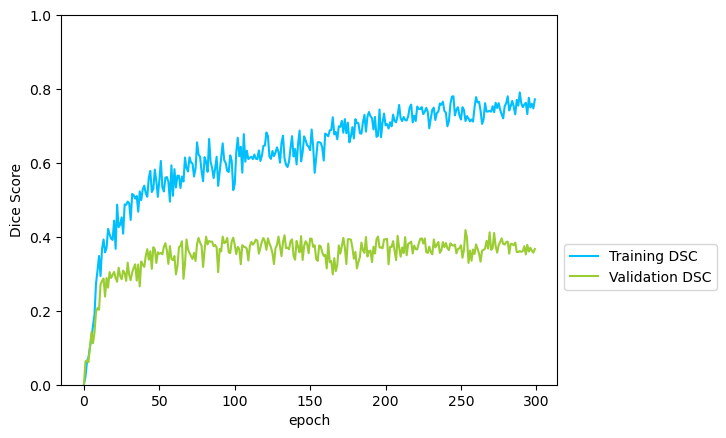


Current Best validation mean DSC: 0.418560


Best validation mean DSC: 0.418560



In [8]:
# train and validation procedure
best_validation_dsc = 0.0

loss_train=[]
loss_valid=[]
allloss_train=[]
alldsc_train=[]
allloss_val=[]
alldsc_val=[]

# actual processing...
step = 0
print("0 Fold")

for epoch in range(epochs):
    for phase in ["train", "valid"]:
        if phase == "train":
            model.train()
        else:
            model.eval()
            
        train_dsc_list=[]
        validation_dsc_list=[]
        
        
        for i, data in enumerate(loaders[phase]):
            if phase == "train": step += 1
            x, y_true = data 
            x, y_true = x.to(device).float(), y_true.to(device).float()
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == "train"): 
                y_pred = model(x) # forwarding     
                loss = 1. - dice(y_pred, y_true)
            
                if phase == "train":
                    loss_train.append(loss.item())
                    
                    y_pred = torch.where(y_pred > 0.5, 1.0, 0.0)
                    dicescore = dice(y_pred, y_true)
                    train_dsc_list.append(dicescore.item())

                    loss.backward()
                    optimizer.step() # backpropagation
                    
                    #plot_img(x[:,:,:,:,50], y_true[:,:,:,:,50], y_pred[:,:,:,:,50])
                    
                if phase == "valid":
                    loss_valid.append(loss.item()) # gathering the loss
                    
                    y_pred = torch.where(y_pred > 0.5, 1.0, 0.0)
                    dicescore = dice(y_pred, y_true)
                    validation_dsc_list.append(dicescore.item())

                    #plot_img(x[:,:,:,:,50], y_true[:,:,:,:,50], y_pred[:,:,:,:,50])
                    
                    
        if phase == "train": # reporting
            print("=================================================")
            print("epoch {} | {}: {}".format(epoch + 1, "Train loss", np.mean(loss_train)))
            print("        | {}: {}".format("Train Dice", np.mean(train_dsc_list)))
            
            allloss_train.append(np.mean(loss_train))
            alldsc_train.append(np.mean(train_dsc_list))
            loss_train=[]

            
        if phase == "valid": #reporting
            print("...................................................")
            print("     | {}: {}".format("Validation loss", np.mean(loss_valid)))
            print("     | {}: {}".format("Validation Dice", np.mean(validation_dsc_list)))

            # save best model
            if np.mean(validation_dsc_list) > best_validation_dsc:
                best_validation_dsc = np.mean(validation_dsc_list)
                torch.save(model.state_dict(), os.path.join(weights+'Lung_seg_3fold.pth'))
                print("\n save dice : {:4f}\n".format(best_validation_dsc))  
            
            alldsc_val.append(np.mean(validation_dsc_list))
            allloss_val.append(np.mean(loss_valid))
            loss_valid=[]


        clear_output()
        plt.plot(allloss_train, label='Trainig loss', color='royalblue')
        plt.plot(allloss_val, label='Validation loss', color='tomato')
        plt.legend(bbox_to_anchor=(1,0.4))
        plt.ylim([0,1])
        plt.xlabel('epoch')
        plt.ylabel('Loss')
        plt.show()

        plt.plot(alldsc_train, label='Training DSC', color='deepskyblue')
        plt.plot(alldsc_val, label='Validation DSC', color='yellowgreen')
        plt.legend(bbox_to_anchor=(1,0.4))
        plt.ylim([0,1])
        plt.xlabel('epoch')
        plt.ylabel('Dice Score')
        plt.show()
        print("\nCurrent Best validation mean DSC: {:4f}\n".format(best_validation_dsc))

print("\nBest validation mean DSC: {:4f}\n".format(best_validation_dsc))

In [11]:
def save_prediction(img, pred, target, output_path, sub_id):
    # Resolve location where data should be written
    if not os.path.exists(output_path):
        raise IOError(
            "Data path, {}, could not be resolved".format(output_path)
        )
            
    # Convert numpy array to NIFTI
    img_nifti = nib.Nifti1Image(img, None)
    pred_nifti = nib.Nifti1Image(pred, None)
    target_nifti = nib.Nifti1Image(target, None)
    
    # Save segmentation to disk
    img_file = "input.nii.gz"
    pred_file = "result.nii.gz"         
    target_file = "target.nii.gz"
    
    nib.save(img_nifti, os.path.join(output_path, img_file))
    nib.save(pred_nifti, os.path.join(output_path, pred_file)) 
    nib.save(target_nifti, os.path.join(output_path, target_file)) 



PATH =  weights+'Lung_seg_3fold.pth'
list_path = '/nasdata4/son/PEstudy_KYJ/Results/cross_3fold.txt'
list = open(list_path, 'r').read().split('\n')
list.remove('')
save_dir='/nasdata4/son/PEstudy_KYJ/Results/3fold'

#model.load_state_dict(torch.load(PATH, map_location=device))
model.load_state_dict(torch.load(PATH))
model.eval()

test_dsc_list = []

with torch.no_grad():
    for i, test_data in enumerate(loader_test):
        test_images, test_targets = test_data
        test_images = test_images.to(device).float() 
        test_targets = test_targets.to(device).float()
        
        test_outputs = model(test_images) 
        
        test_outputs = torch.where(test_outputs>0.5, 1.0, 0.0)
        dicescore = dice(test_outputs, test_targets)
        test_dsc_list.append(dicescore.item())

        print("[{}]  DICE: {:.3f}".format(list[i], dicescore))
        print("------------------------------------------------------------------------")
        
        test_images = test_images.squeeze()
        test_targets = test_targets.squeeze()
        test_outputs = test_outputs.squeeze()
        test_images = test_images.detach().cpu().numpy()
        test_targets = test_targets.detach().cpu().numpy()
        test_outputs = test_outputs.detach().cpu().numpy()
        
        # save nifti
        subject_ID = list[i]
        output_path = save_dir+'/'+list[i]
        save_prediction(img=test_images,
                        pred=test_outputs, 
                        target=test_targets, 
                        output_path=output_path,
                        sub_id=subject_ID
                        )

print("평균 BIG   DSC: {:.3f}".format(np.mean(test_dsc_list)))

[LUNG1-005]  DICE: 0.309
------------------------------------------------------------------------
[LUNG1-026]  DICE: 0.907
------------------------------------------------------------------------
[LUNG1-042]  DICE: 0.350
------------------------------------------------------------------------
[LUNG1-088]  DICE: 0.811
------------------------------------------------------------------------
[LUNG1-115]  DICE: 0.482
------------------------------------------------------------------------
[LUNG1-156]  DICE: 0.798
------------------------------------------------------------------------
[LUNG1-205]  DICE: 0.390
------------------------------------------------------------------------
[LUNG1-229]  DICE: 0.722
------------------------------------------------------------------------
[LUNG1-249]  DICE: 0.185
------------------------------------------------------------------------
[LUNG1-291]  DICE: 0.699
------------------------------------------------------------------------
[LUNG1-348]  DICE: 0

In [ ]:
with torch.no_grad():
    for i, test_data in enumerate(loader_test):
        test_images, test_targets = test_data
        test_images = test_images.to(device).float() 
        test_targets = test_targets.to(device).float()
        
        test_outputs = model(test_images) 
        test_outputs = torch.where(test_outputs>0.5, 1.0, 0.0)
        
        
         
        print("*******************************************************************************************")
        print("*******************************************************************************************")
        print("--------------------------------------------[{}]--------------------------------------------".format(list[i]))
        print("*******************************************************************************************")
        print("*******************************************************************************************")
        
        for i in range(test_images.size()[-1]):
            plot_img(test_images[:,:,:,:,i], test_targets[:,:,:,:,i], test_outputs[:,:,:,:,i])